In [165]:
# Install dependencies
!pip install numpy
!pip install matplotlib
!pip install scipy

In [166]:
# Import dependencies
import numpy as np
import matplotlib.pyplot as plt

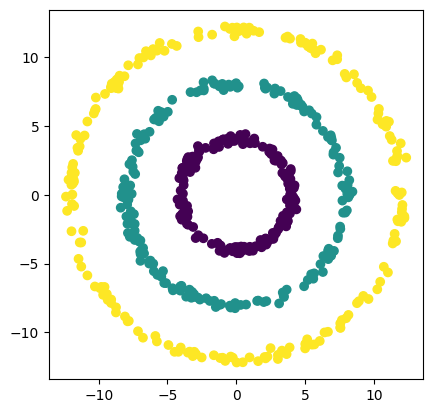

In [167]:
# Generate example data (concentric circles with noise)
noise = 0.2
point_count = 200
radii = [4, 8, 12]
circles = len(radii)

data = np.zeros((circles, point_count, 2))
full_labels = np.zeros(circles * point_count)
for c in range(circles):
    thetas = np.random.rand((point_count)) * 360
    radii_now = np.full((point_count), radii[c]) + np.random.normal(0, noise, size=(point_count)) 
    data[c, :, :] = np.array([np.cos(thetas) * radii_now, np.sin(thetas) * radii_now]).T
    full_labels[(c * point_count):((c+1) * point_count)] = np.full((point_count), c)

# Reshape
data = data.reshape(circles * point_count, 2)

# Plot data
plt.scatter(data[:, 0], data[:, 1], c=full_labels, cmap='viridis')
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.draw()

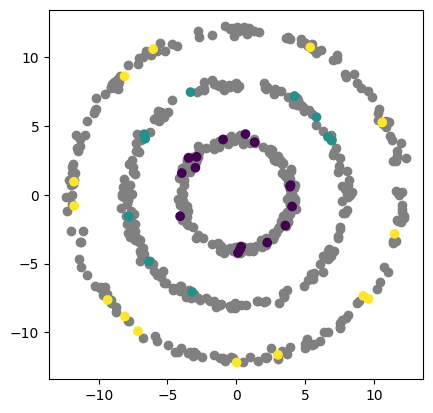

In [168]:
# Separate into labeled and unlabeled sets
labeled_count = 40
indices = np.random.choice(np.arange(circles * point_count), (labeled_count,), replace=False)
mask = np.array([(i in indices) for i in range(len(data))])

labeled = data[mask]
unlabeled = data[~mask]
labels = full_labels[mask]
reconst = np.concatenate((labeled, unlabeled))

plt.scatter(data[~mask, 0], data[~mask, 1], c='gray')
plt.scatter(data[mask, 0], data[mask, 1], c=full_labels[mask])
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.draw()

In [169]:
# Define kernels and derivatives
def gaussian_kernel(x, y, sigma):
    return np.exp(-np.linalg.norm(x - y)**2 / (2 * sigma**2))

def gaussian_deriv(x, y, sigma, i):
    # Derivative w.r.t ith component of 1st argument
    return -(x[i] - y[i]) / (sigma ** 2) * gaussian_kernel(x, y, sigma)

In [178]:
import math
import scipy

n = len(reconst)
p = math.ceil(math.log(n))
d = reconst.shape[1]
SIG = 1.5
MU = 0.00000001
LAMBDA = 0.00000001

SnTa = np.zeros((n, p))
for i in range(n):
    for j in range(p):
        SnTa[i][j] = gaussian_kernel(reconst[i], reconst[j], SIG)

ZnTa = np.zeros((d * n, p))
for i in range(p):
    for l in range(n):
        for j in range(d):
            ZnTa[l * d + j][i] = gaussian_deriv(reconst[l], reconst[i], SIG, j)

TaSigTa = (1 / n) * SnTa.T @ SnTa
TaLTa = (1 / n) * ZnTa.T @ ZnTa
TaTa = np.zeros((p, p))
for i in range(p):
    for j in range(p):
        TaTa[i][j] = gaussian_kernel(reconst[i], reconst[j], SIG)

eigenvalues, eigenvectors = scipy.linalg.eigh(TaSigTa, TaLTa + MU * TaTa)
eigenvectors = eigenvectors.reshape(p, p, 1)

b = np.zeros((p))
for j in range(p):
    s = 0
    for i in range(labeled_count):
        s += labels[i] * gaussian_kernel(reconst[i], reconst[j], SIG)
    b[j] = (1 / labeled_count) * s

c = np.zeros((p))
for i in range(p):
    c += (1 / (eigenvalues[i] + LAMBDA)) * (eigenvectors[i] @ eigenvectors[i].T @ b)

def g_est(x):
    g_hat_p = 0
    
    # Iterate over each basis function
    for j in range(p):
        # Compute phi_j(x)
        phi_j_x = 0
        for i in range(n):
            phi_j_x += SnTa[i, j] * gaussian_kernel(x, data[i], SIG)
        
        # Add contribution of c_j * phi_j(x) to g_hat_p(x)
        g_hat_p += c[j] * phi_j_x
    return g_hat_p

In [186]:
g_est(np.array([0, 0]))

np.float64(7.307686039406065)